In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import seaborn as sns
import pickle
import collections

In [2]:
## loading the data

data=pd.read_pickle('stage_2_data_for_clustering.pkl')

## add another step if you want to filter by interval

## interval='WC A'
## data=data.loc[data['Interval]==interval]

data.head()

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS Interval
11008.0  ANASAZI `16` STATE 1  2.865  103.895  2.594  68.471  15.191     WC A
11008.5  ANASAZI `16` STATE 1  2.809   98.146  2.595  67.866  14.876     WC A
11009.0  ANASAZI `16` STATE 1  2.764   93.175  2.598  67.542  14.776     WC A
11009.5  ANASAZI `16` STATE 1  2.820   87.963  2.601  67.714  15.113     WC A
11010.0  ANASAZI `16` STATE 1  2.938   86.100  2.597  68.097  15.504     WC A

In [3]:
## logs vary a lot in scales, so we use standardscaler 

from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
x_scaled=scale.fit_transform(data[['PEFWS', 'GRWS', 'DENWS', 'DTWS',]])


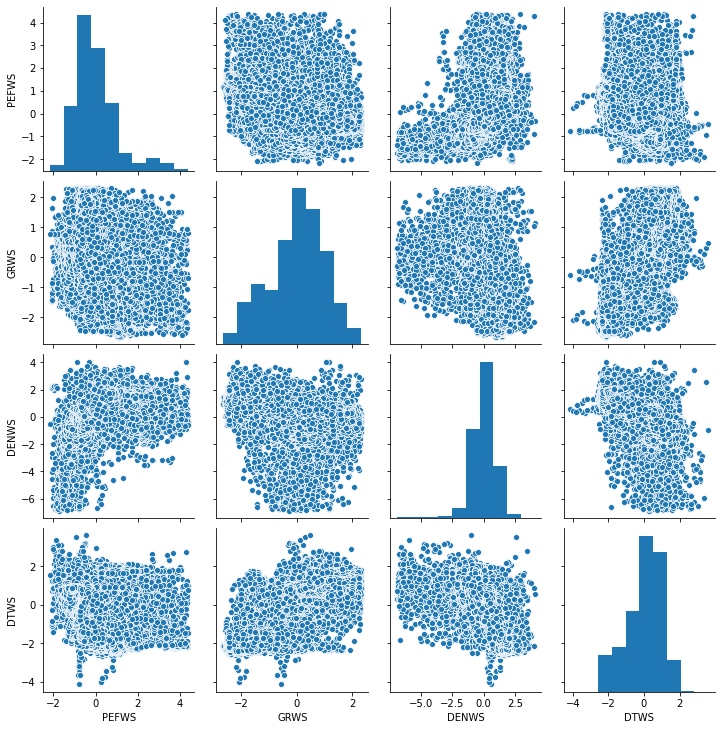

In [6]:
## visualizing the scaled data

labelled_dataframe = pd.DataFrame(data = x_scaled, columns = ['PEFWS', 'GRWS', 'DENWS', 'DTWS'])
sns.pairplot(labelled_dataframe) # Create a matrix scatterplot

### finding numer of clusters present in the data

Text(0, 0.5, 'Within-cluster Sum of Squares')

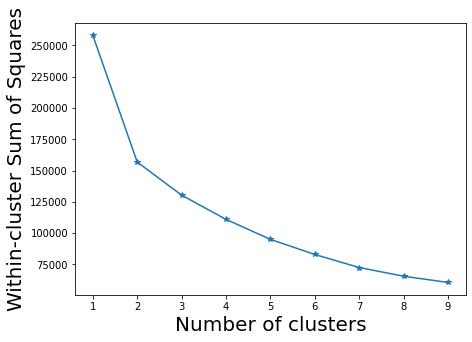

In [7]:
## Method 1: elbow curve

wcss = []  # Store within sum of square values for each cluster size
cl_num = 10 # Total number of clusters
for i in range (1,cl_num):
    kmeans = KMeans(i, random_state=10) 
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_ # calculates the wcss
    wcss.append(wcss_iter)
    
number_clusters = range(1,cl_num)
plt.figure(figsize=(7,5))
plt.plot(number_clusters, wcss, '*-')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('Within-cluster Sum of Squares',fontsize=20)

In [8]:
## method 2: silhoutte score..the higher the better

from sklearn.metrics import silhouette_score
range_n_clusters = [2,3,4,5,6,7] # Number of clusters
for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)
    
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.40087079557044003
For n_clusters = 3 The average silhouette_score is : 0.24525004223279956
For n_clusters = 4 The average silhouette_score is : 0.2721232935596678
For n_clusters = 5 The average silhouette_score is : 0.25442992109072765
For n_clusters = 6 The average silhouette_score is : 0.26766531290764795
For n_clusters = 7 The average silhouette_score is : 0.27323912725940613


In [9]:
## method 3: gap statistics to find optimal clusters...the higher, the better

%matplotlib inline
import time
import hashlib
import scipy

def optimalK(data, nrefs, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, 
                                                       #index 2 = 3 clusters are optimal

In [12]:
k, gapdf = optimalK(x_scaled, nrefs=3, maxClusters=9)

print ('Optimal k is:', k)

Optimal k is: 7


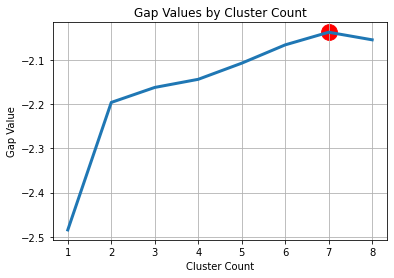

In [13]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

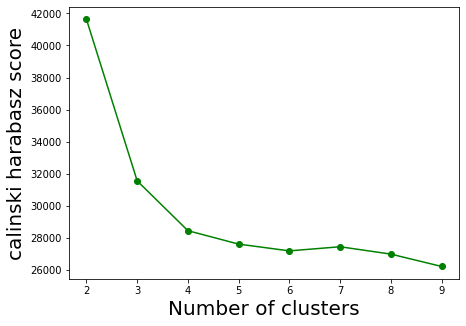

In [17]:
## method 4: calinski_harabasz_score...the higher, the better

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

num_clusters=[]
ch_score=[]

for k in range(2, 10):
    num_clusters.append(k)
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x_scaled)
    labels = kmeans_model.labels_
    ch_score.append(calinski_harabasz_score(x_scaled, labels))
    

plt.figure(figsize=(7,5))
plt.plot(num_clusters, ch_score, '-o', color='green')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('calinski harabasz score',fontsize=20)
plt.show()

Text(0, 0.5, 'davies bouldin score')

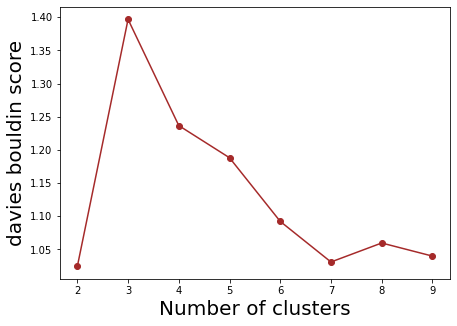

In [19]:
## method 5: davies boulding score..the closer to 0, the better

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score 

num_clusters=[]
db_score=[]

for k in range(2, 10):
    num_clusters.append(k)
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(x_scaled)
    labels = kmeans_model.labels_
    db_score.append(davies_bouldin_score(x_scaled, labels))
    

plt.figure(figsize=(7,5))
plt.plot(num_clusters, db_score, '-o', color='brown')
plt.xlabel('Number of clusters',fontsize=20)
plt.ylabel('davies bouldin score',fontsize=20)

In [20]:
db_score

[1.0243055859434613,
 1.3968730826241702,
 1.236715766333535,
 1.188187808017047,
 1.0922252881687575,
 1.0310255473521315,
 1.0596616119348736,
 1.039910157644115]

## Clustering

In [7]:
## clustering using kmeans

n_clusters=3
km=KMeans(n_clusters=n_clusters, n_init=10, random_state=10)
km.fit(x_scaled)

KMeans(n_clusters=3, random_state=10)

In [8]:
collections.Counter(km.labels_)

Counter({1: 30195, 0: 21871, 2: 12424})

In [5]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

In [ ]:
! ## code breaks, dont run


hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
hc.fit_predict(x_scaled)

In [26]:
metrics.adjusted_rand_score(km.labels_, hc.labels_)

0.2809357558413158

In [9]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, n_init=20, affinity='nearest_neighbors', n_neighbors=15,
             assign_labels="discretize",
             random_state=0).fit(x_scaled)

In [10]:
data['facies_km']=km.labels_
data['facies_sc']=sc.labels_

In [11]:
data.head()

WELL  PEFWS     GRWS  DENWS    DTWS  DRESWS Interval  \
11008.0  ANASAZI `16` STATE 1  2.865  103.895  2.594  68.471  15.191     WC A   
11008.5  ANASAZI `16` STATE 1  2.809   98.146  2.595  67.866  14.876     WC A   
11009.0  ANASAZI `16` STATE 1  2.764   93.175  2.598  67.542  14.776     WC A   
11009.5  ANASAZI `16` STATE 1  2.820   87.963  2.601  67.714  15.113     WC A   
11010.0  ANASAZI `16` STATE 1  2.938   86.100  2.597  68.097  15.504     WC A   

         facies_km  facies_sc  
11008.0          1          0  
11008.5          1          0  
11009.0          1          0  
11009.5          1          0  
11010.0          1          0

In [12]:
data.to_pickle('entire_wolfcamp_clustering_results.pkl')

In [26]:
data['Interval'].unique()

array(['WC A', 'WC B', 'WC D upper', 'WC D lower', 'WC C'], dtype=object)

In [30]:
df1=data.loc[data['Interval']=='WC D lower']

In [31]:
## visulaizing the logs alongside the facies labels

from matplotlib import colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
facies_colors = ['#996633','#ffff00','#000000']

def make_facies_log_plot(data, well_name, label1, label2):
    logs=data.loc[(data['WELL']==well_name)]
    #make sure logs are sorted by depth
    #logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    #color_dict={0:'red', 1:'blue', 2:'green', 4:'yellow'}
    
    ztop=logs.index.min(); zbot=logs.index.max()
    
    cluster1=np.repeat(np.expand_dims(logs[label1].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs[label2].values,1), 100, 1)
    #cluster=logs['facies_km']
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(14, 16))
    ax[0].plot(logs.DTWS, logs.index, '-g', linewidth=3)
    ax[1].plot(logs.GRWS, logs.index, '-', linewidth=3)
    ax[2].plot(logs.PEFWS, logs.index, '-', linewidth=3, color='0.5')
    ax[3].plot(logs.DENWS, logs.index, '-', linewidth=3, color='r')
    #ax[4].plot(logs.facies_km, logs.index, color='black', linewidth =1)
    #ax[4].xaxis.label.set_color("black")
    #ax[4].tick_params(axis='x', colors="black")
    #ax[4].spines["top"].set_edgecolor("black")
    
    #im=ax[4].imshow(logs[label].values.reshape(len(logs),1),cmap=cmap_facies, interpolation='none',
    #                aspect='auto',vmin=0,vmax=3)
    
    im1=ax[4].imshow(cluster1,cmap=cmap_facies, interpolation='none',
                    aspect='auto',vmin=0,vmax=3)
    im2=ax[5].imshow(cluster2,cmap=cmap_facies, interpolation='none',
                    aspect='auto',vmin=0,vmax=3)
    
    
    #divider1 = make_axes_locatable(ax[4])
    #cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    divider2 = make_axes_locatable(ax[5])
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    
    cbar=plt.colorbar(im2, cax=cax2)
    cbar.set_label((35*' ').join(['0', '1', 
                                '2']),fontsize=16)
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    #for key in color_dict.keys():
    #    ax[4].fill_betweenx(logs.index, 0, logs.facies_km, where=(data['facies_km']==key),facecolor=color_dict[key])
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        #ax[i].set_ylim(10000,15500)
        ax[i].invert_yaxis()
        ax[i].grid(linewidth=1.2, c='black')
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].tick_params(which='both', labelsize=14)
    
    ax[0].set_xlabel("DTWS",fontsize=16)
    ax[0].set_xlim(logs.DTWS.min(),logs.DTWS.max())
    ax[1].set_xlabel("GRWS",fontsize=16)
    ax[1].set_xlim(logs.GRWS.min(),logs.GRWS.max())
    ax[2].set_xlabel("PEFWS",fontsize=16)
    ax[2].set_xlim(logs.PEFWS.min(),logs.PEFWS.max())
    ax[3].set_xlabel("DENWS",fontsize=16)
    ax[3].set_xlim(logs.DENWS.min(),logs.DENWS.max())
    #ax[4].set_xlabel("PE")
    #ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[4].set_xlabel('%s'%label1,fontsize=16)
    ax[5].set_xlabel('%s'%label2,fontsize=16)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    #ax[1].set_ylim(np.arange(min(logs.index), max(logs.index), step=200))
    ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])
    ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%well_name, fontsize=20,y=0.94)

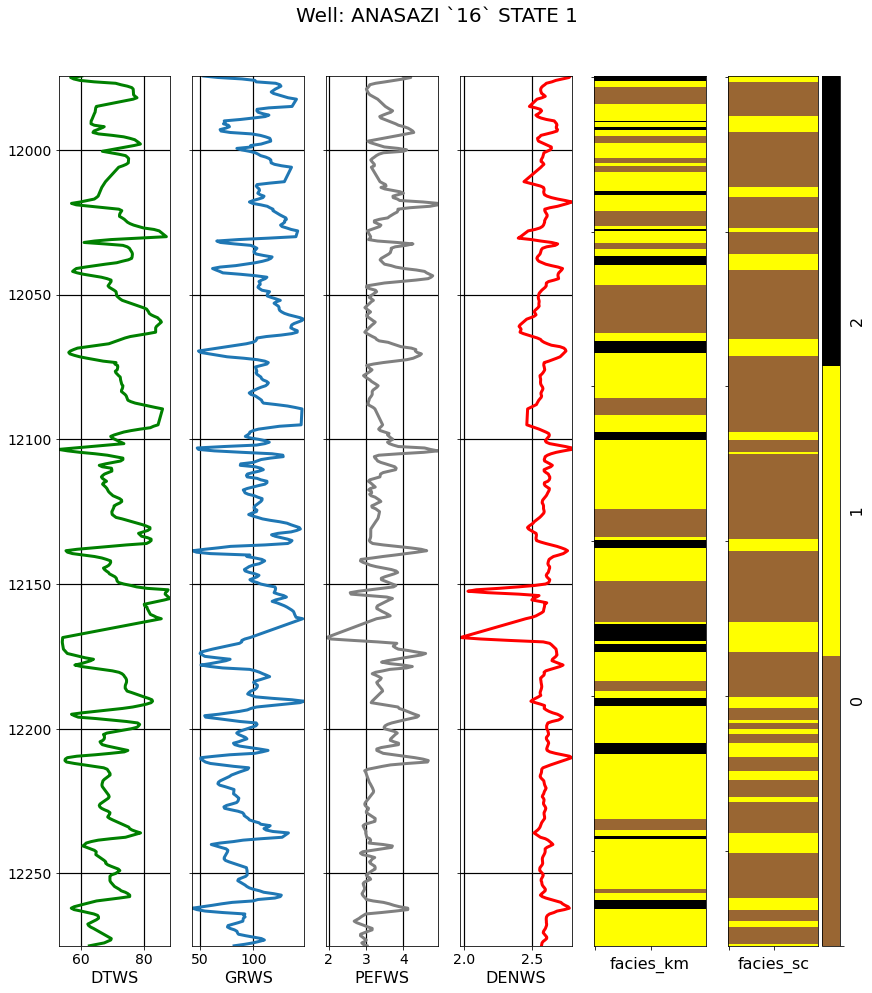

In [32]:
make_facies_log_plot(df1, df1['WELL'].iloc[0], 'facies_km','facies_sc')

/scratch/user/eliza95/.conda/envs/elsaenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/scratch/user/eliza95/.conda/envs/elsaenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/scratch/user/eliza95/.conda/envs/elsaenv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may 

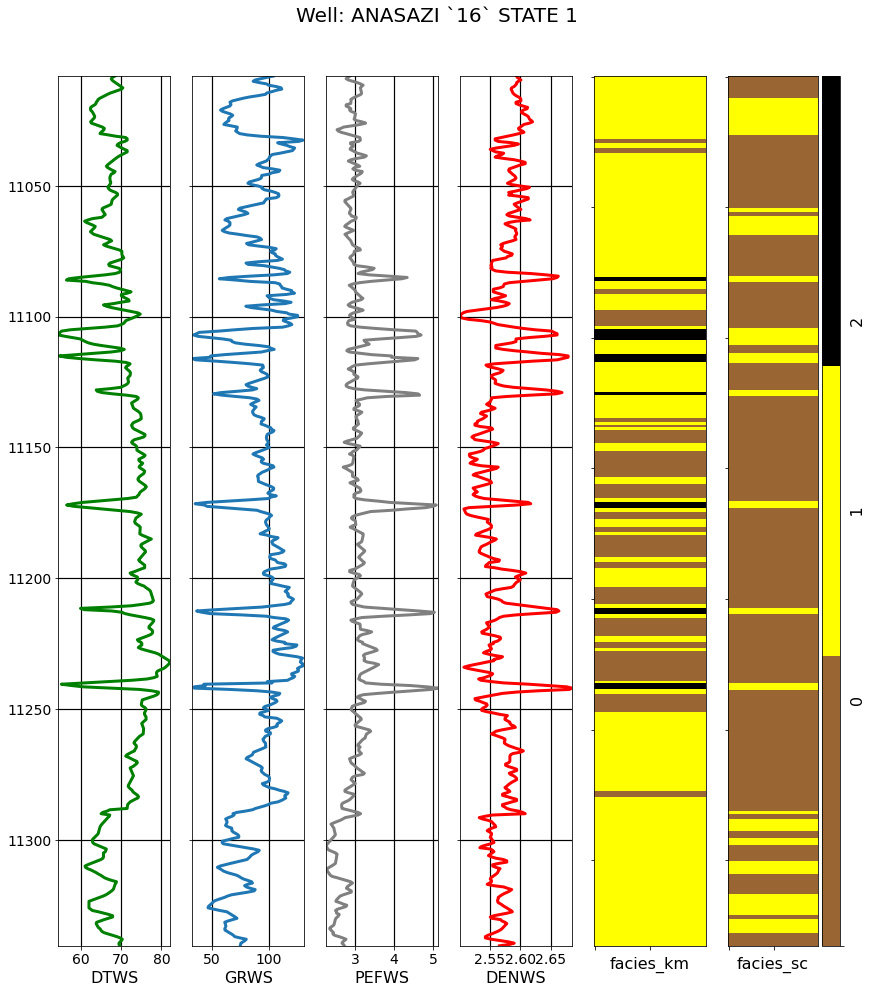

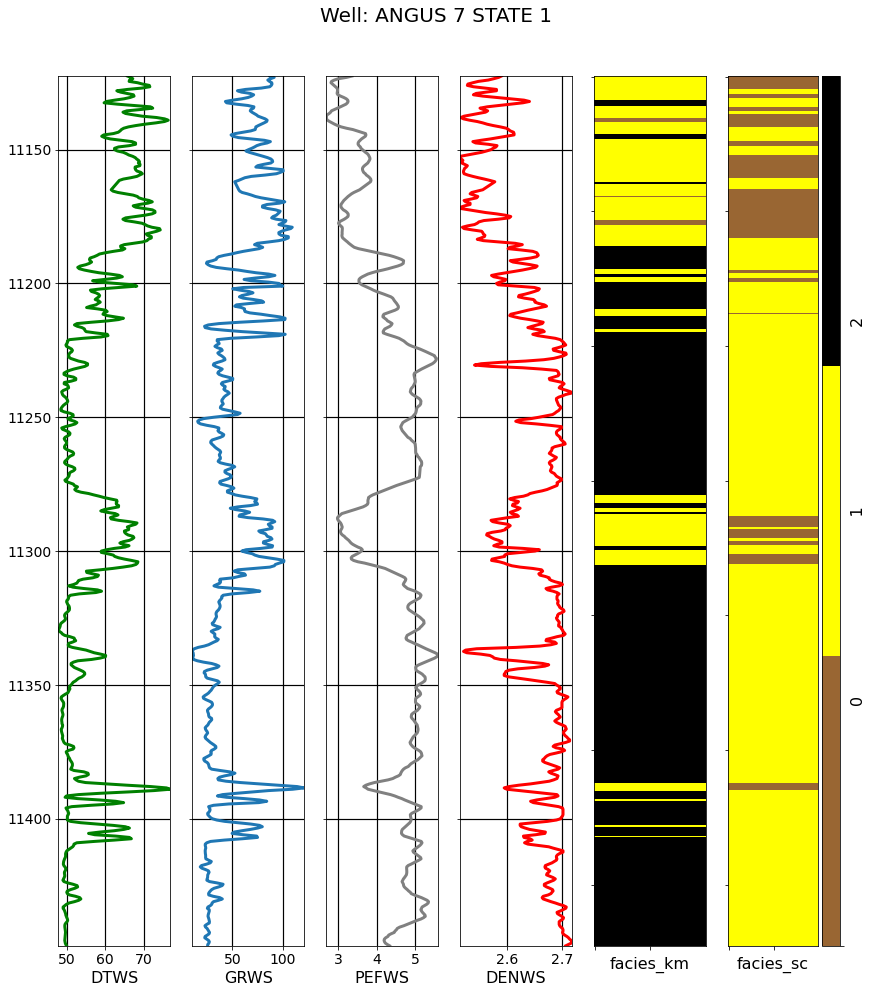

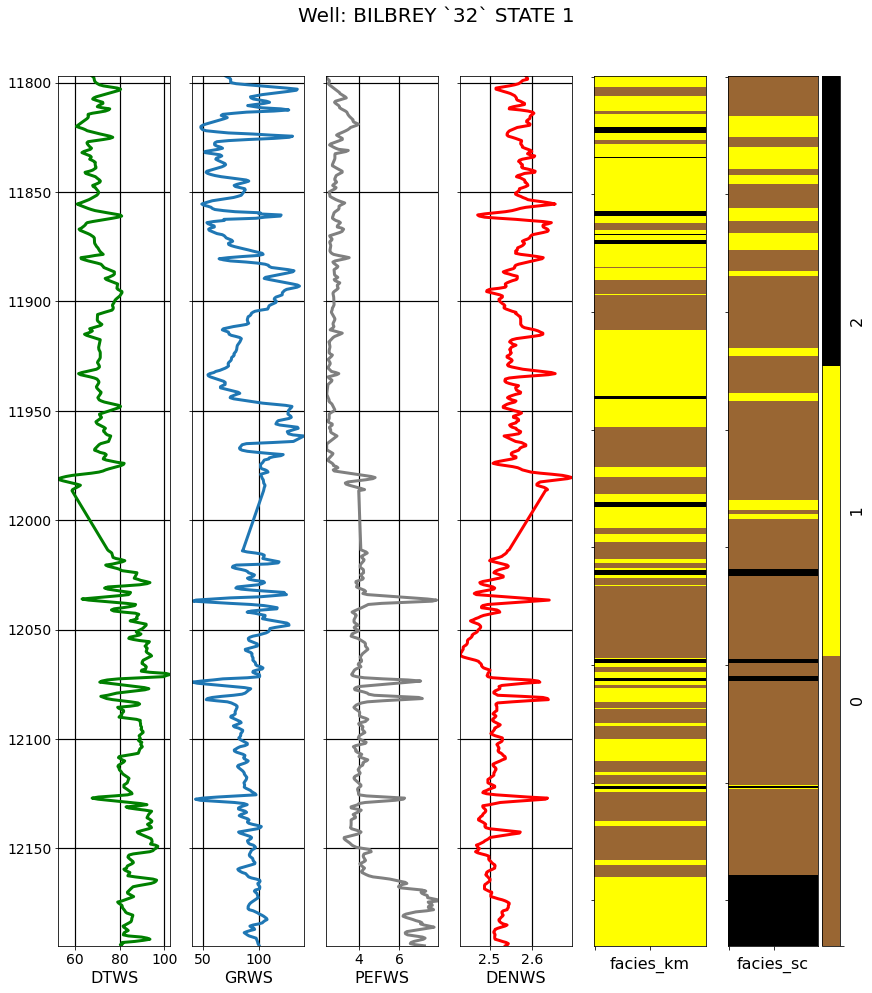

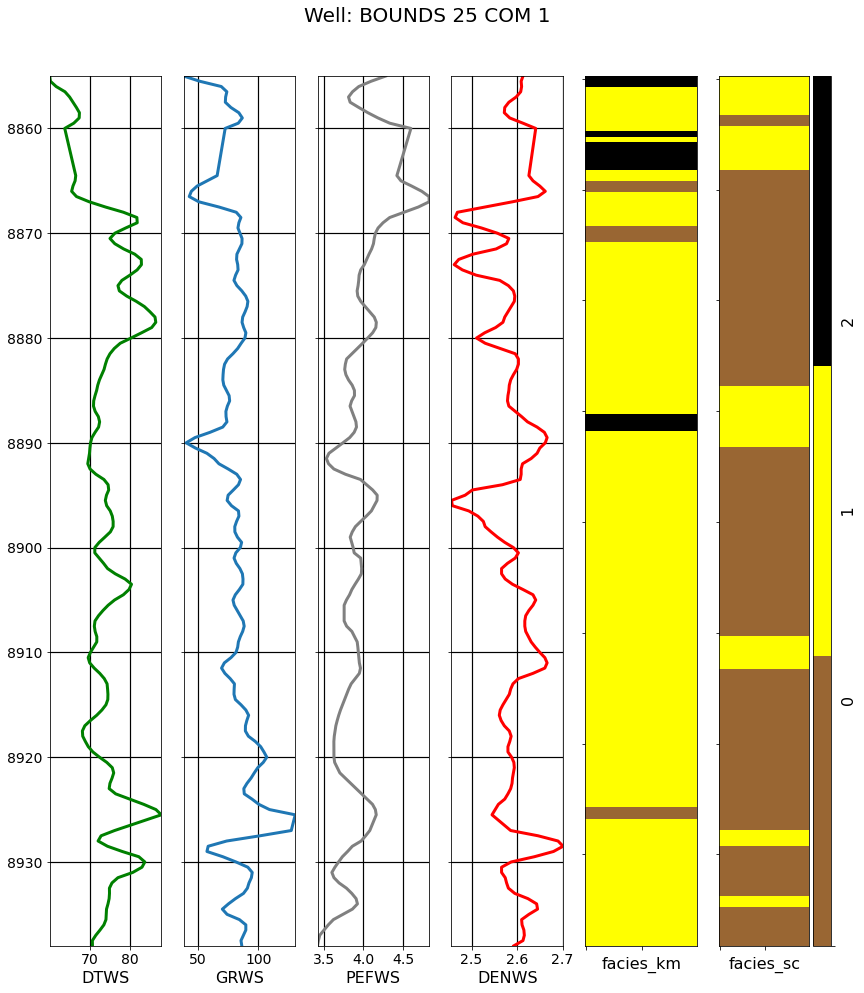

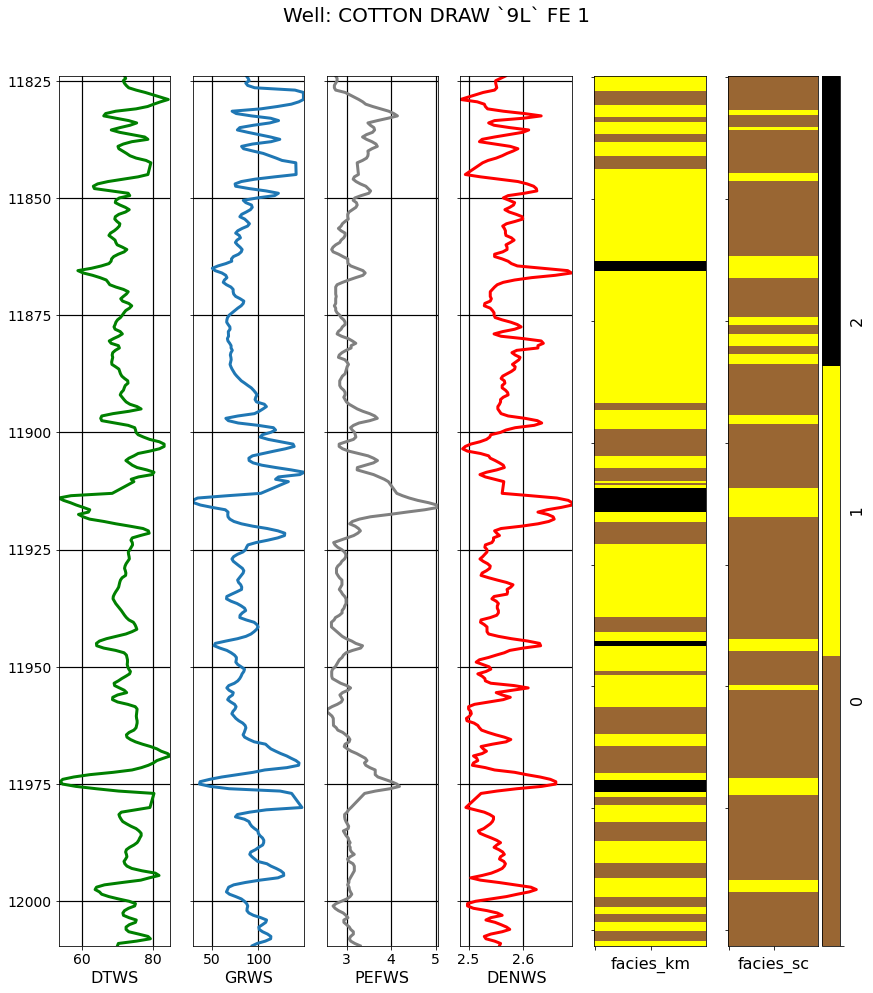

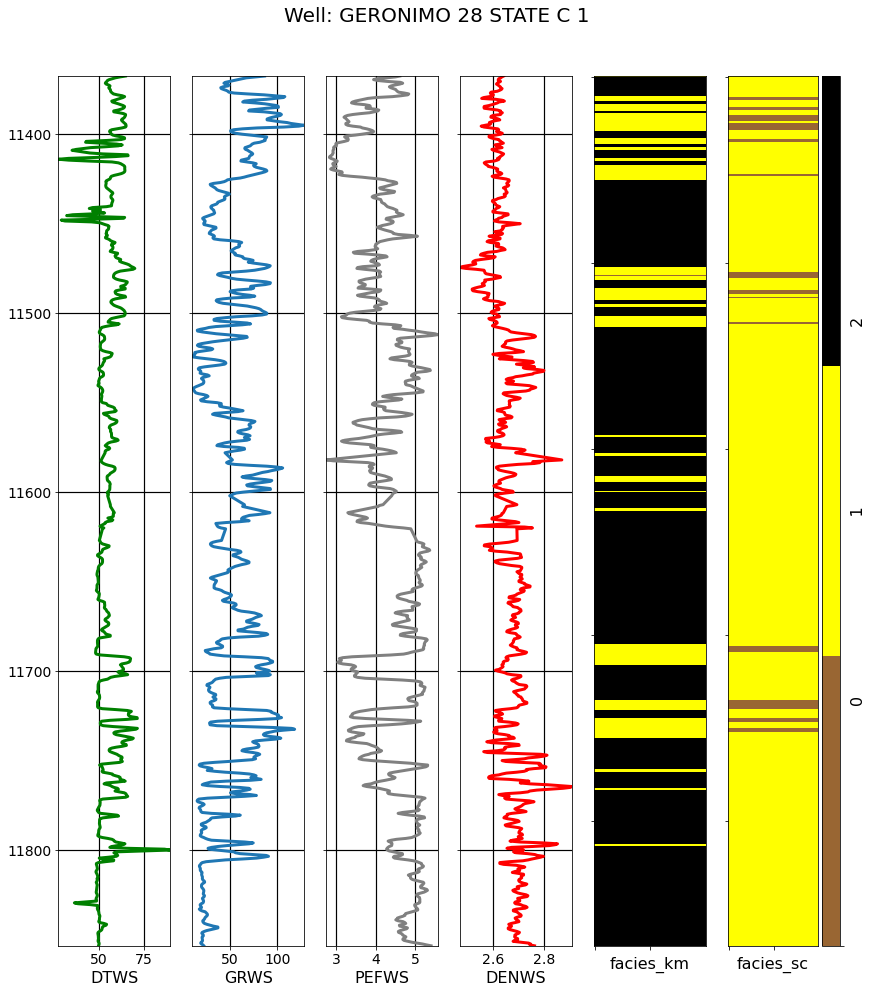

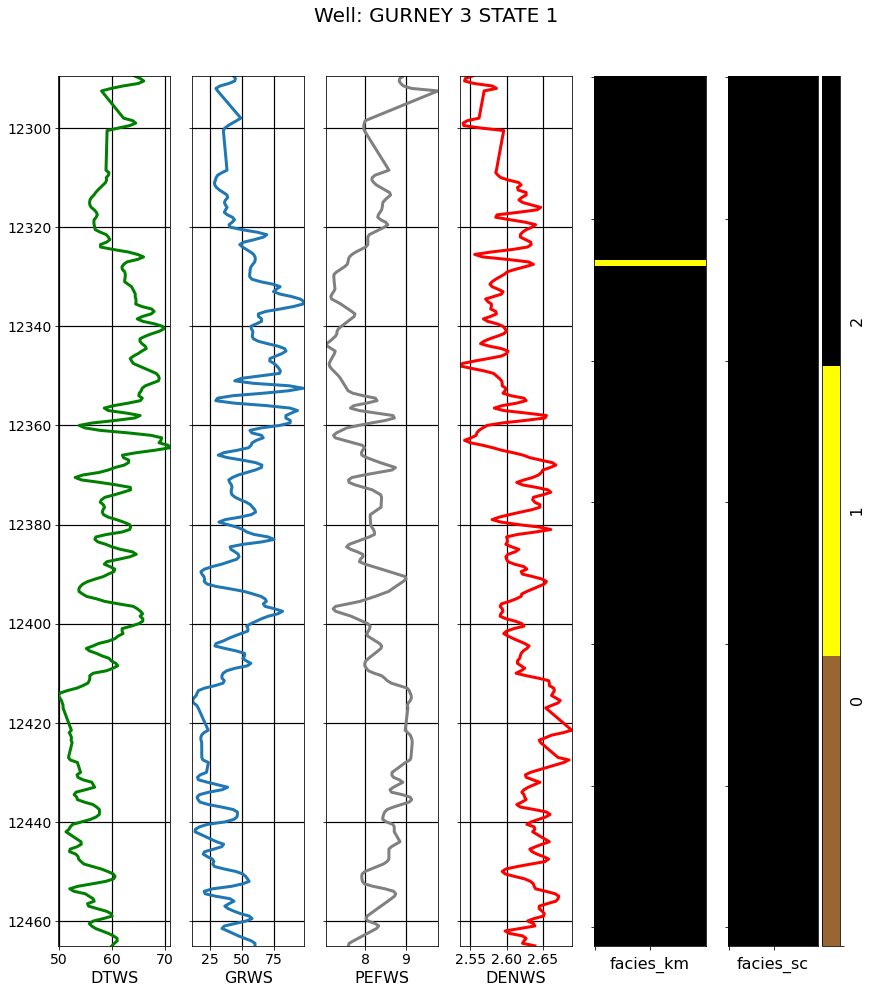

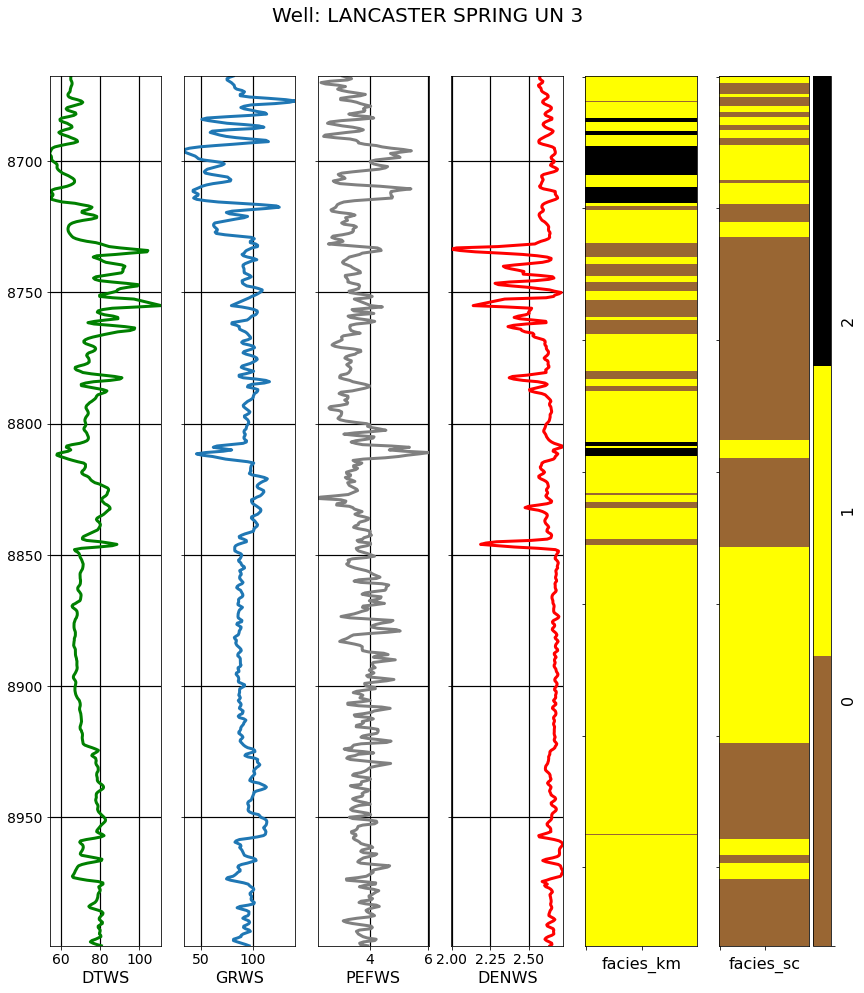

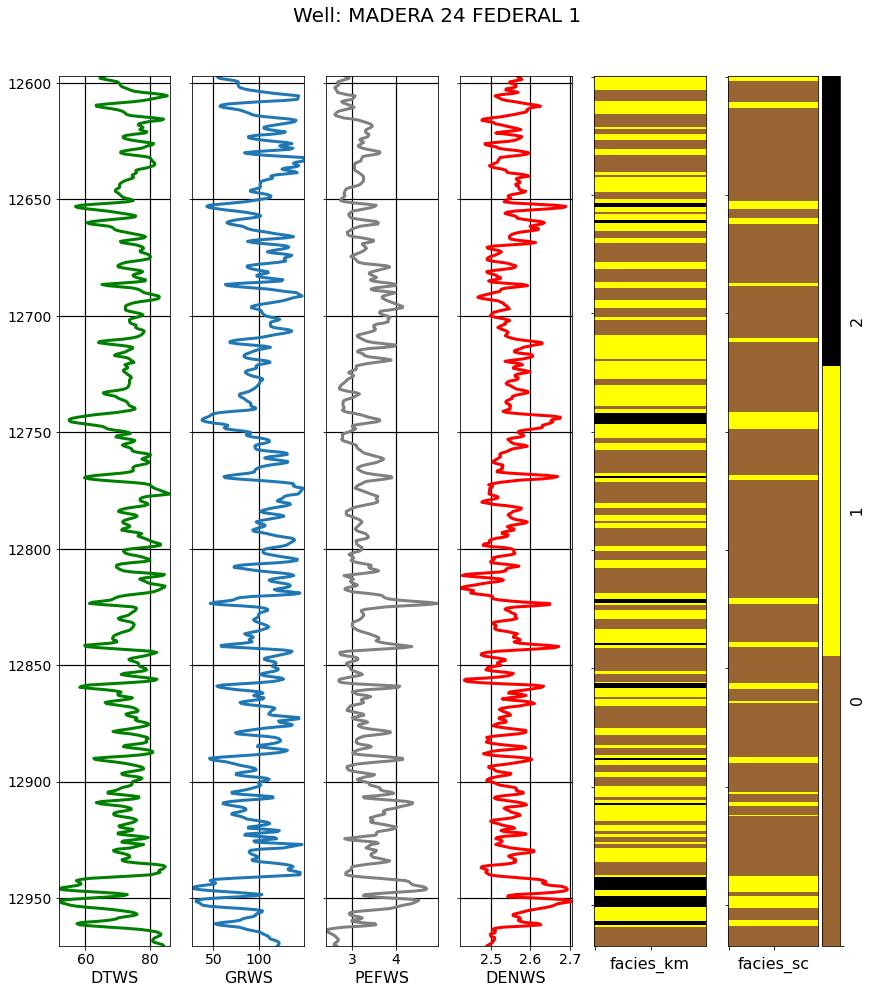

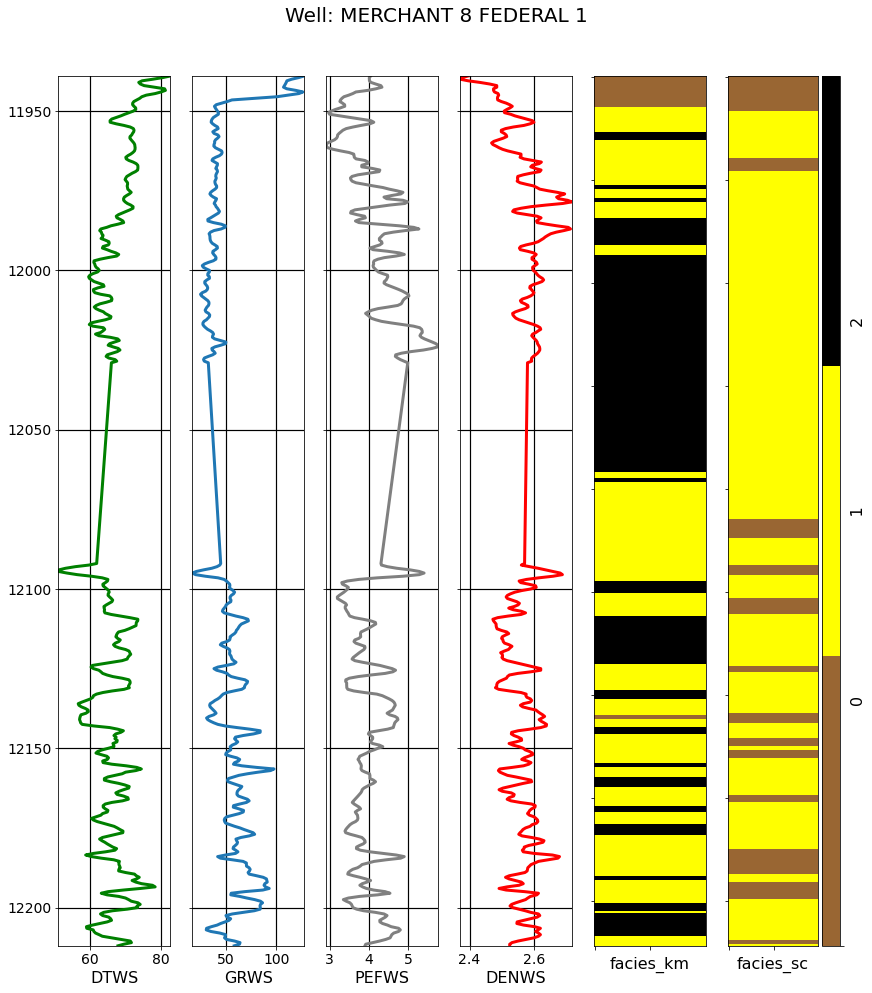

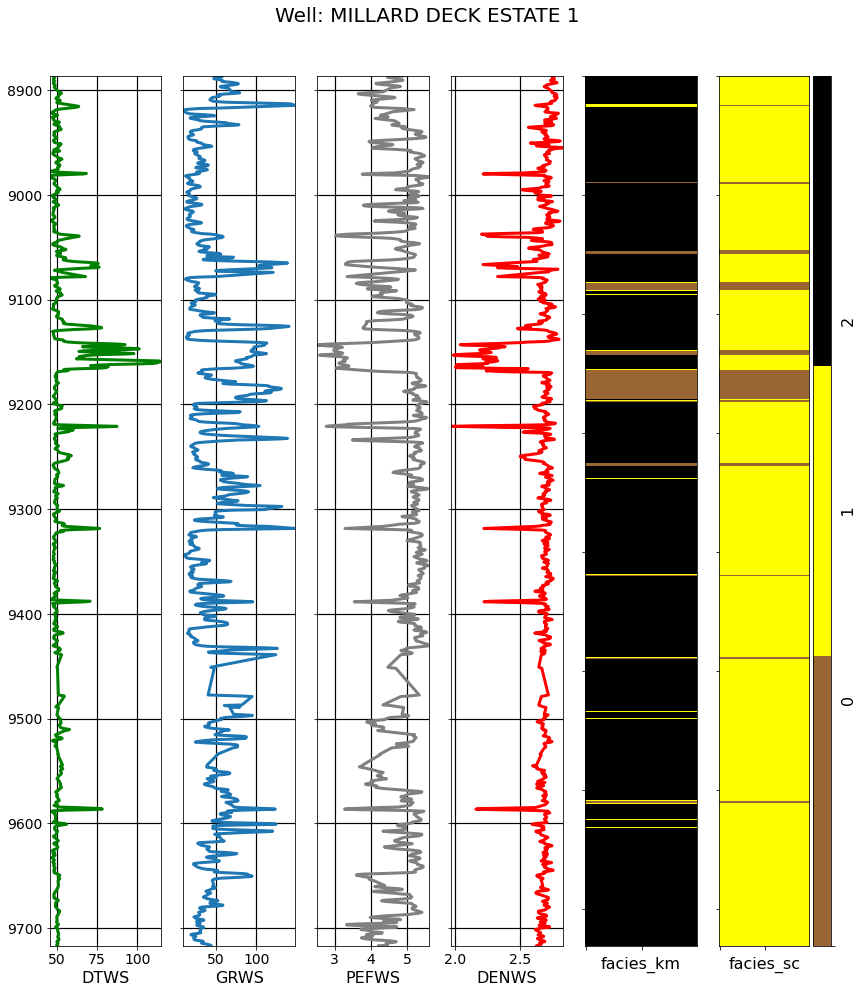

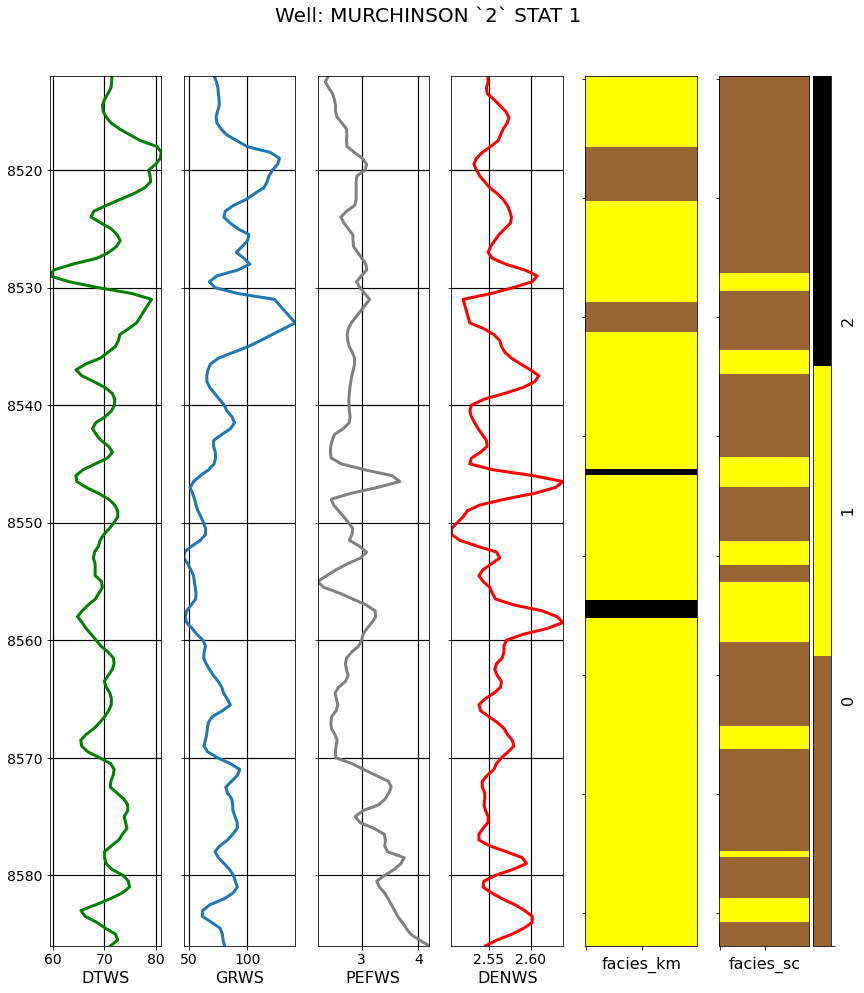

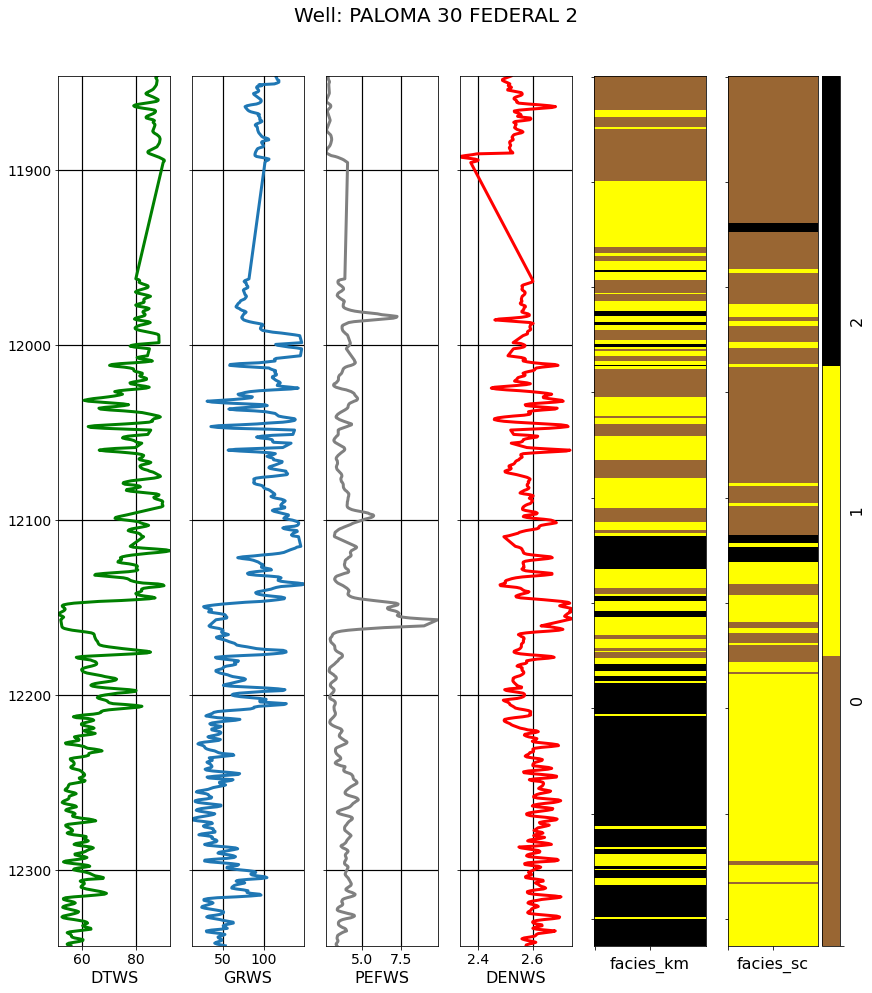

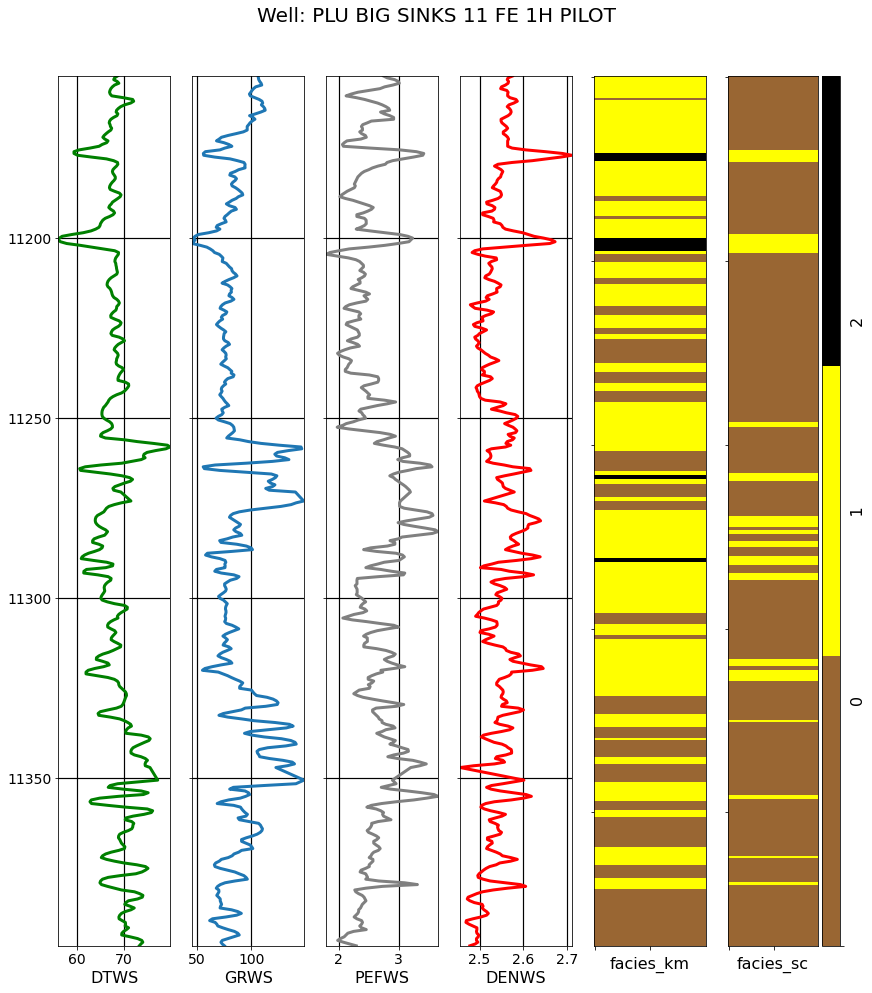

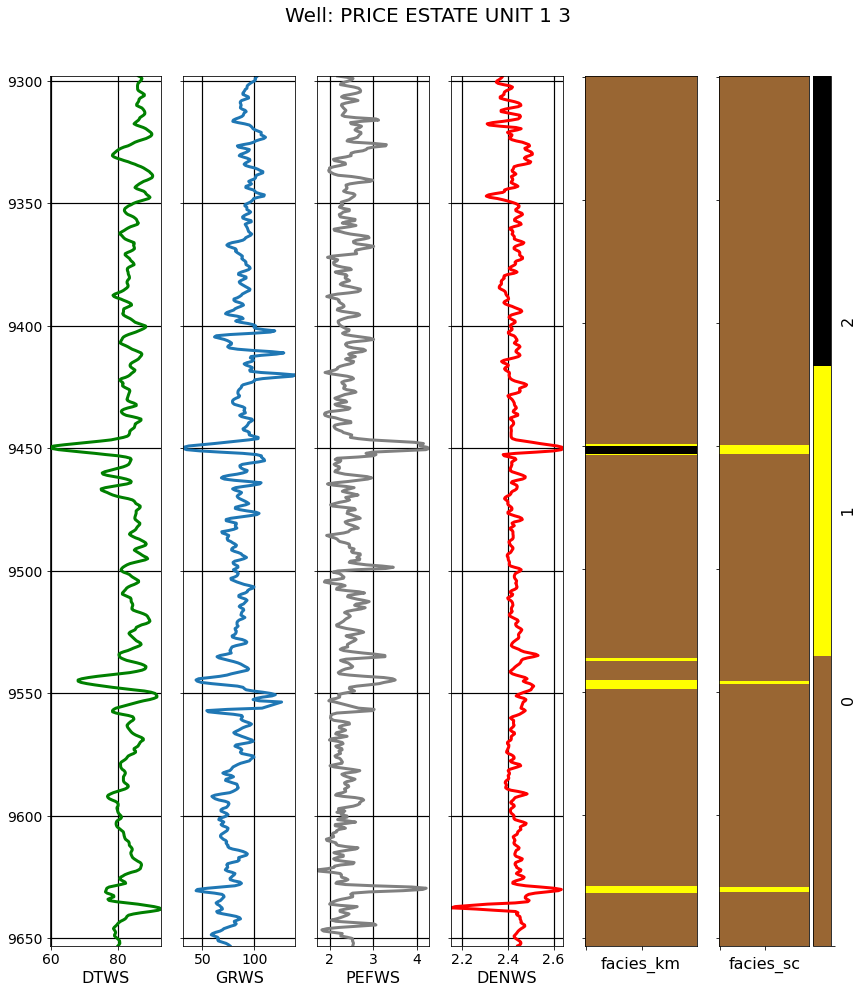

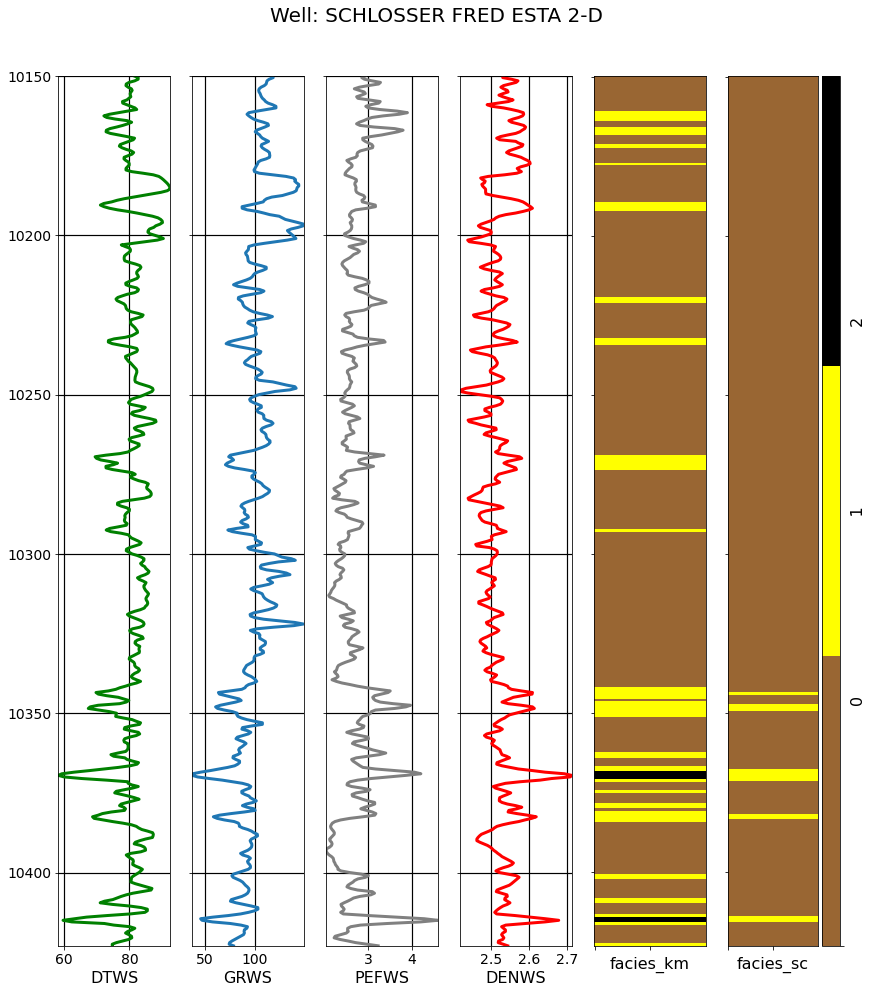

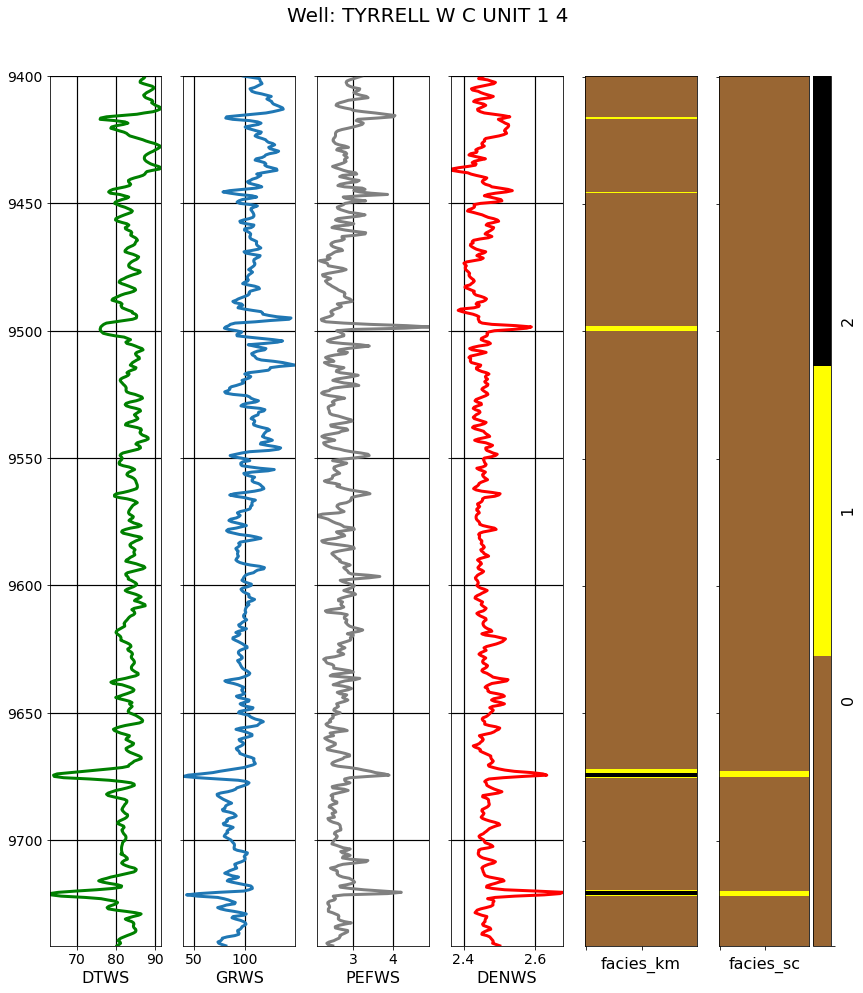

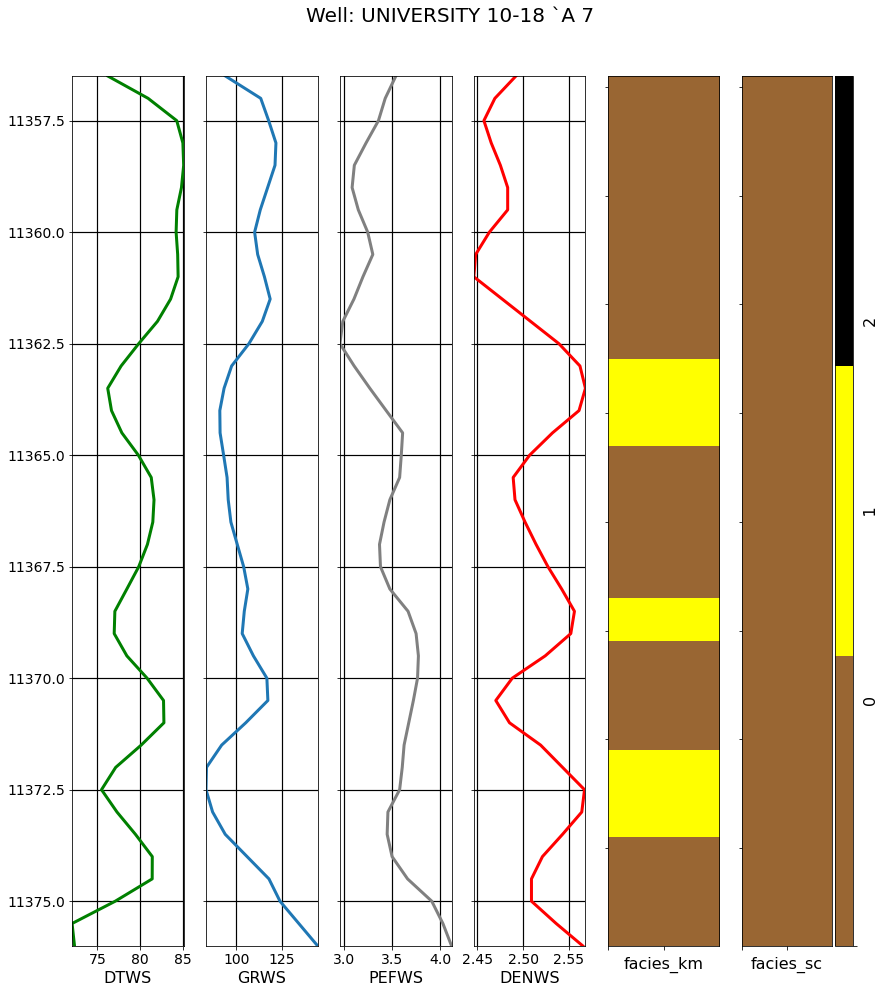

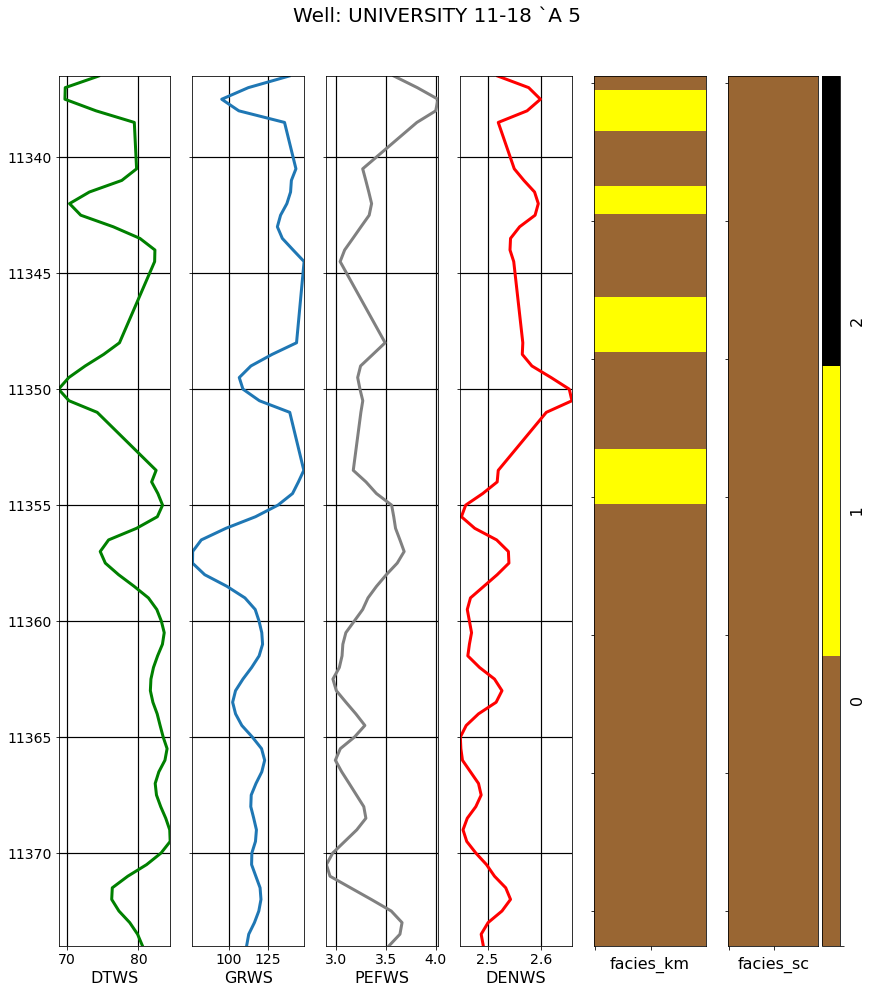

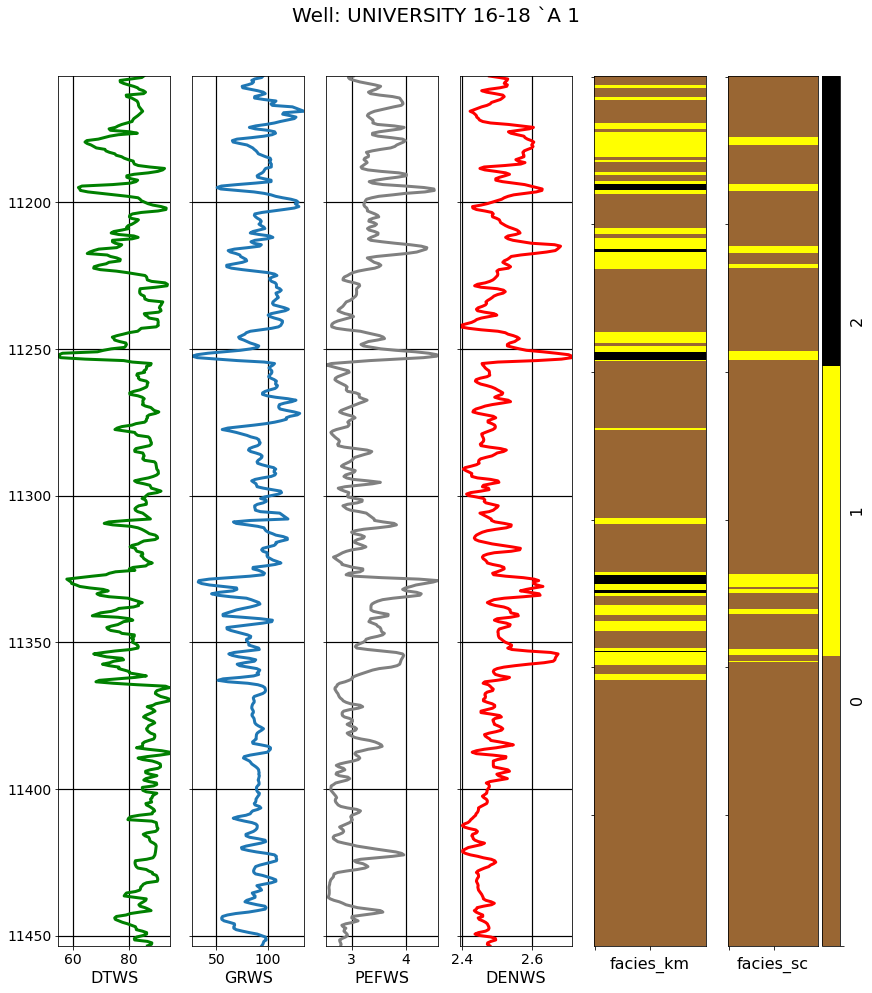

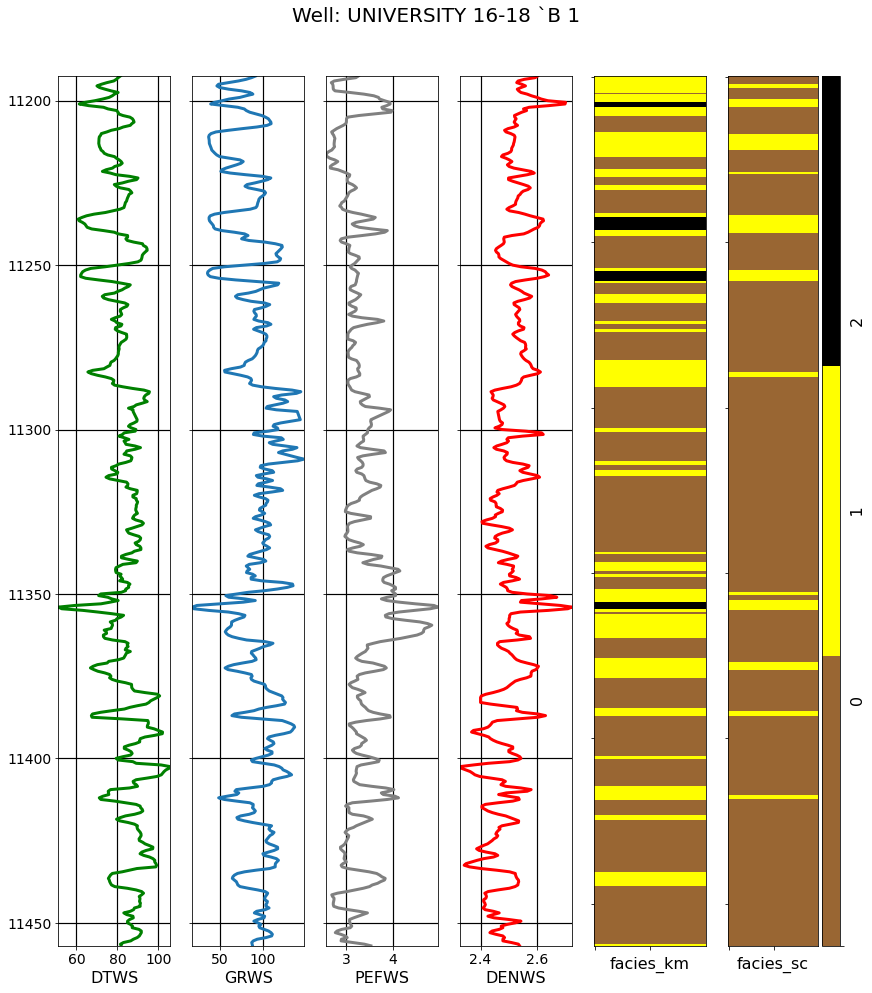

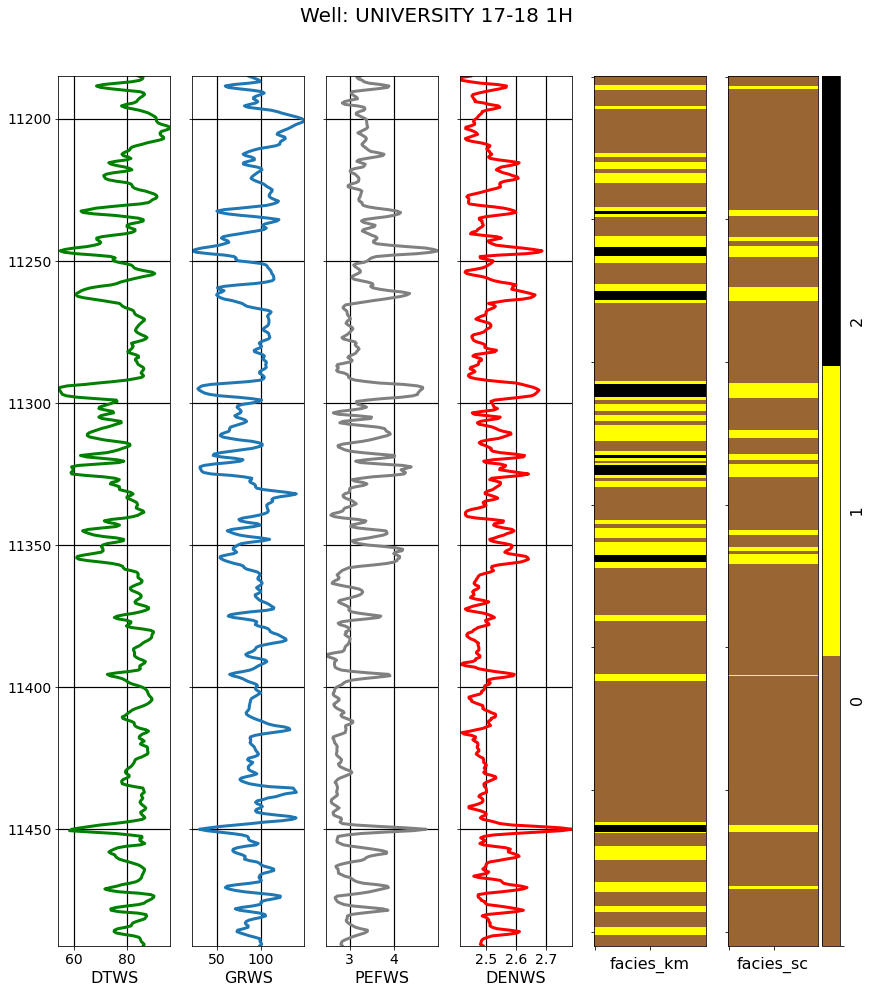

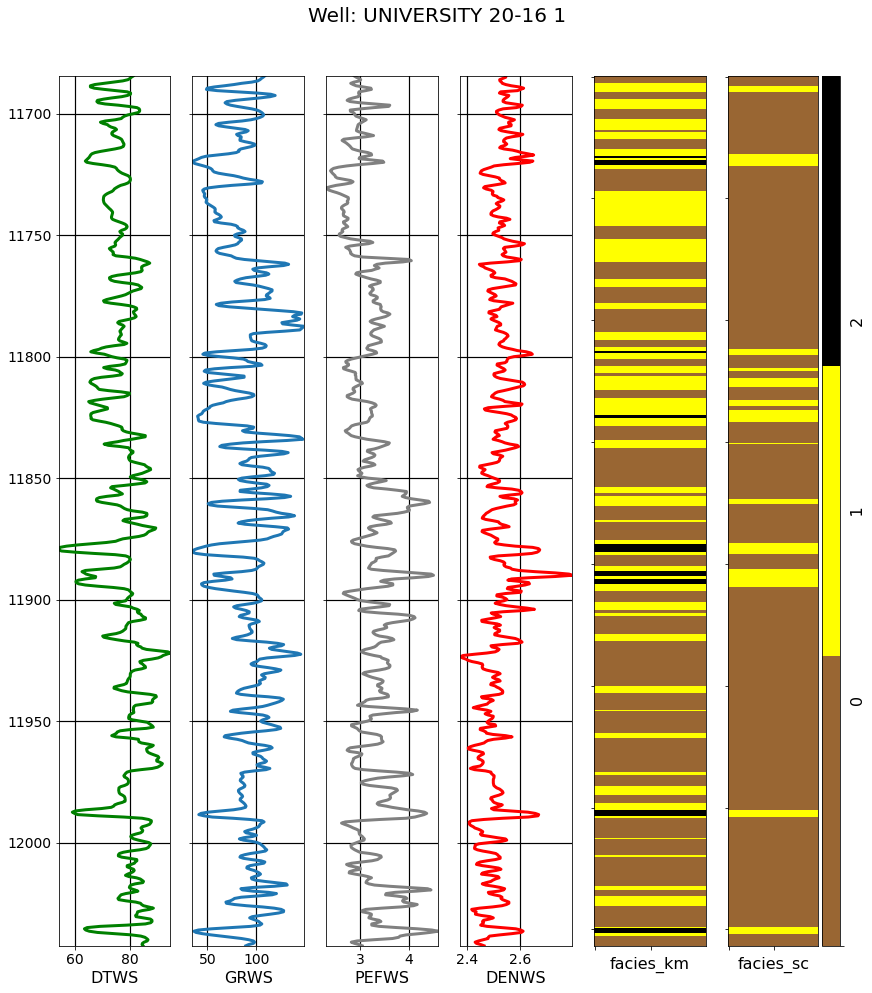

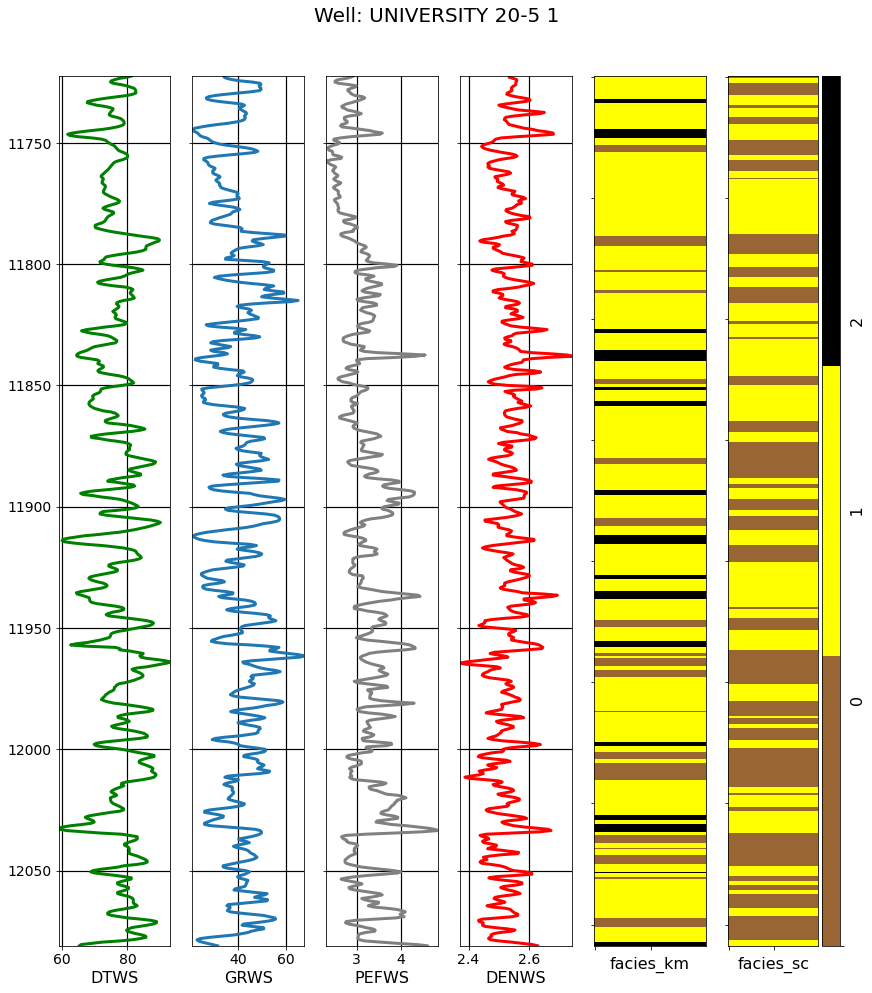

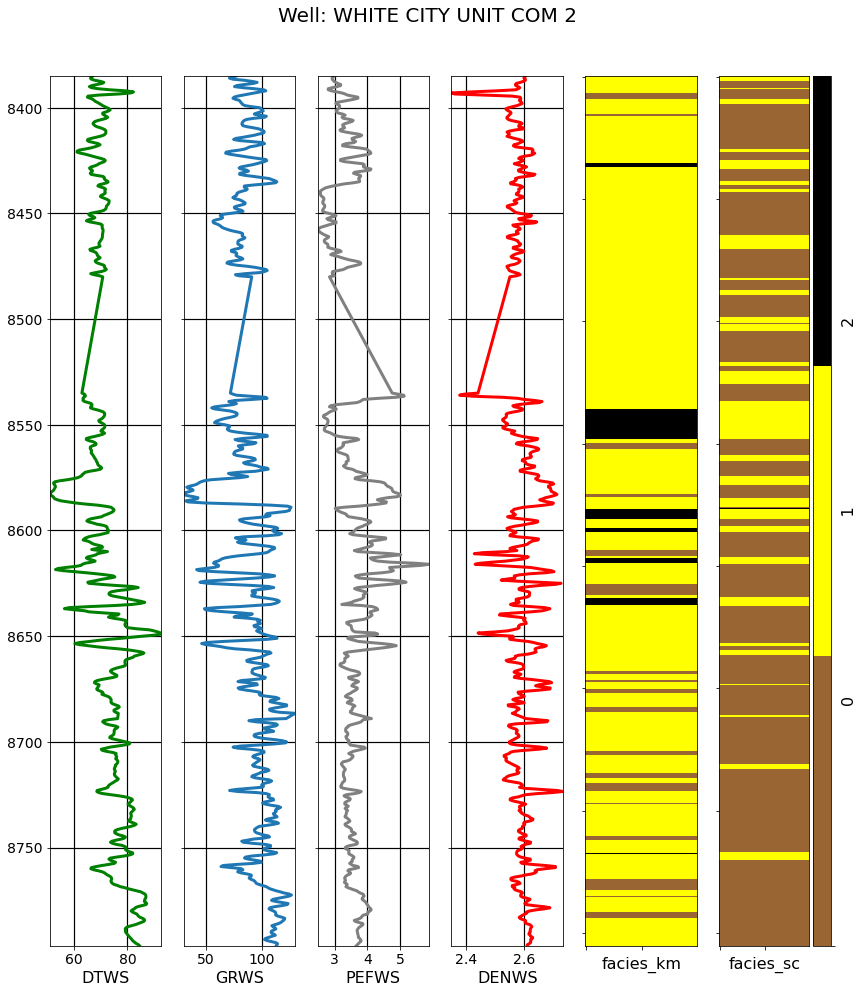

In [10]:
well_list=np.unique(df1['WELL'])
for i in well_list:
    make_facies_log_plot(df1, i, 'facies_km','facies_sc')